# LSTM Intent Classification
---
**Dataset:** bbc news (250 samples) News contents with 5 categories (Sport, Business, Politics, Tech and Others)

**Model:**   multiclass classification model : LSTM

**Training:**  Colab (GPU)  

**Process:**  1. Dataset Load  ➔ 2. Data processing ➔ 3. Model Training  ➔ 4. Model Evaluation ➔ 5. Prediction

**Result:**  Accuracy = 0.50, run time = 3 minutes

## ライブラリ

In [ ]:
#　ライブラリ

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## 1. データ読み込

In [ ]:
# google driveと接続

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# intent, unique_intent, sentencesに分ける

def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", header=0)
  print(df.head())
  category = df["category"]
  unique_category = list(set(category))
  text = list(df["text"])
  
  return (df, category, unique_category, text)

In [ ]:
# データ読み込

dataset = "/content/drive/My Drive/dataset/bbc/bbc-text250.csv"
df, category, unique_category, text = load_dataset(dataset)

   category                                               text
0  business  worldcom boss  left books alone  former worldc...
1  business  virgin blue shares plummet 20% shares in austr...
2  business  crude oil prices back above $50 cold weather a...
3  business  s korean credit card firm rescued south korea ...
4  business  japanese banking battle at an end japan s sumi...


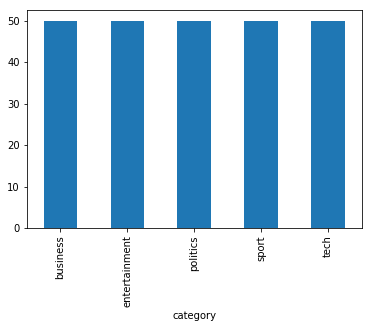

In [ ]:
import matplotlib.pyplot as plt

df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

In [ ]:
# サンプルデータを確認

print(text[:5])

['worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing an $11bn (Â£5.8bn) fraud  never made accounting decisions  a witness has told jurors.  david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors.  on monday  defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination  he asked mr myers if he ever knew mr ebbers  make an accounting decision  .  not that i am aware of   mr myers replied.  did you ever know mr ebbers to make an accounting entry into worldcom books   mr weingarten pressed.  no   replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief finan

## 2. データ準備

In [ ]:
# nltkのstopwordsとtokenizersを読み込む

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#define stemmer
stemmer = LancasterStemmer()

In [ ]:
# データクリーニング

def cleaning(text):
  words = []
  for s in text:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words

cleaned_words = cleaning(text)
print(len(cleaned_words))
print(cleaned_words[:2])  

250
[['worldcom', 'boss', 'left', 'books', 'alone', 'former', 'worldcom', 'boss', 'bernie', 'ebbers', 'who', 'is', 'accused', 'of', 'overseeing', 'an', '11bn', '5', '8bn', 'fraud', 'never', 'made', 'accounting', 'decisions', 'a', 'witness', 'has', 'told', 'jurors', 'david', 'myers', 'made', 'the', 'comments', 'under', 'questioning', 'by', 'defence', 'lawyers', 'who', 'have', 'been', 'arguing', 'that', 'mr', 'ebbers', 'was', 'not', 'responsible', 'for', 'worldcom', 's', 'problems', 'the', 'phone', 'company', 'collapsed', 'in', '2002', 'and', 'prosecutors', 'claim', 'that', 'losses', 'were', 'hidden', 'to', 'protect', 'the', 'firm', 's', 'shares', 'mr', 'myers', 'has', 'already', 'pleaded', 'guilty', 'to', 'fraud', 'and', 'is', 'assisting', 'prosecutors', 'on', 'monday', 'defence', 'lawyer', 'reid', 'weingarten', 'tried', 'to', 'distance', 'his', 'client', 'from', 'the', 'allegations', 'during', 'cross', 'examination', 'he', 'asked', 'mr', 'myers', 'if', 'he', 'ever', 'knew', 'mr', 'ebbe

In [ ]:
# Tokenizerを作成

def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

# max_lengthの設定
def max_length(words):
  return(len(max(words, key = len)))


word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
#max_length = max_length(cleaned_words)
max_length = 50

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 10613 and Maximum length = 50


In [ ]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

padded_doc = padding_doc(encoded_doc, max_length)

In [ ]:
padded_doc[:5]

array([[1058,    5,    1, 1979, 3279, 4196,   54,   62,    1,  139, 2720,
        3273, 1059,  321,   52, 5878,    5,  431,   91, 1744,  321,   38,
         557,   30, 1740, 1057,    9,  240,    2,   66,   76,  206,    5,
          63,  312, 1176,    1,  187, 4197, 1177,    4, 2306, 3280, 3281,
          15,   20, 3282, 1421,   29, 5879],
       [  20, 3284,   92,   17,   41,  188,  476, 1299, 4199,   35,  263,
           2,    1, 5890,    6,  112,  128, 2308, 1746, 1178, 1060,    8,
         388, 2723, 1747,    2,  595,  406,  120,   13,  825,  388,    6,
          41,  680, 4202, 2309, 2310,   35, 2724, 3285,    3, 1178, 1060,
          36, 1061, 1748,   22,    1,  595],
       [  11,   50,    9,   28,   37, 5907, 1982,    6,    1,  107,    1,
        3290,    3, 1753,    6,    1, 1582, 4208,   26, 1583, 1985,   13,
        3291,    3,   53,  967,    5, 3292,   35,   24,   39,    2,  597,
         725,   59,   21,   34,   81,   66,   42, 1424, 3291,   56,  220,
         598,  270, 11

In [ ]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (250, 50)


In [ ]:
# tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_category, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [ ]:
output_tokenizer.word_index

{'business': 2, 'entertainment': 3, 'politics': 5, 'sport': 1, 'tech': 4}

In [ ]:
# Tokenizer

encoded_output = encoding_doc(output_tokenizer, category)

encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

encoded_output.shape

(250, 1)

In [ ]:
# one hot encoder

def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

output_one_hot = one_hot(encoded_output)

output_one_hot.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(250, 5)

In [ ]:
# 学習とテストを分ける

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_doc, output_one_hot, shuffle = True,  stratify = category, test_size = 0.2, random_state=11)

print("Shape of X_train = %s and y_train = %s" % (X_train.shape, y_train.shape))
print("Shape of X_test = %s and y_test = %s" % (X_test.shape, y_test.shape))


Shape of X_train = (200, 50) and y_train = (200, 5)
Shape of X_test = (50, 50) and y_test = (50, 5)


## 3. 学習

In [ ]:
# モデルの設定

def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation = "softmax"))
  
  return model

model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 128)           1358464   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_9 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 165       
Total params: 1,630,021
Trainable params: 271,557
Non-trainable params: 1,358,464
_________________________________________________________________


In [ ]:
# モデル学習
from datetime import datetime

start_time = datetime.now()

filename = 'model1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(X_train, y_train, epochs = 50, batch_size = 25, validation_data = (X_test, y_test), callbacks = [checkpoint])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Train on 200 samples, validate on 50 samples
Epoch 1/50
200/200 [==============================] - 6s 29ms/step - loss: 1.6105 - acc: 0.1750 - val_loss: 1.6092 - val_acc: 0.3200

Epoch 00001: val_loss improved from inf to 1.60918, saving model to model1.h5
Epoch 2/50
200/200 [==============================] - 2s 9ms/step - loss: 1.6043 - acc: 0.2750 - val_loss: 1.6083 - val_acc: 0.2000

Epoch 00002: val_loss improved from 1.60918 to 1.60826, saving model to model1.h5
Epoch 3/50
200/200 [==============================] - 2s 9ms/step - loss: 1.5993 - acc: 0.3150 - val_loss: 1.6073 - val_acc: 0.2200

Epoch 00003: val_loss improved from 1.60826 to 1.60729, saving model to model1.h5
Epoch 4/50
200/200 [==============================] - 2s 9ms/step - loss: 1.5928 - acc: 0.3250 - val_loss: 1.6052 - val_acc: 0.2400

Epoch 00004: val_loss improved from 1.60729 to 1.60523, saving model to model1.h5
Epoch 5/50
200/200 [==============================] - 2s 10ms/step - loss: 1.5799 - acc: 0.4000 - 

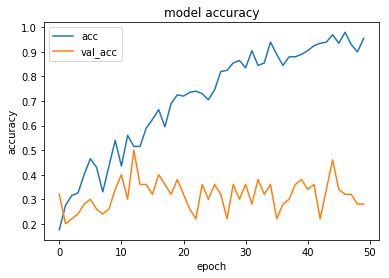

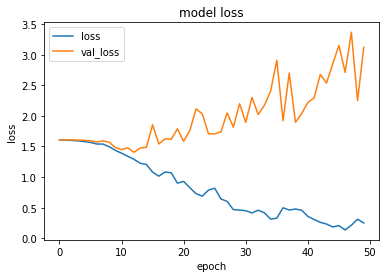

In [ ]:
def plot_history(hist):
    #print(hist.history.keys())

    # 精度の履歴をプロット
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()

# 学習履歴をプロット
plot_history(hist)

In [ ]:
# モデルの設定

model = load_model("model1.h5")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#ytest = np.array(y_test)
ytest = np.argmax(y_test, axis=1)
pd = model.predict(X_test)
prediction = pd.argmax(1)


# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, prediction))
print(confusion_matrix(ytest, prediction))

              precision    recall  f1-score   support

           0       0.46      0.60      0.52        10
           1       0.62      0.50      0.56        10
           2       0.57      0.40      0.47        10
           3       0.50      0.70      0.58        10
           4       0.38      0.30      0.33        10

    accuracy                           0.50        50
   macro avg       0.51      0.50      0.49        50
weighted avg       0.51      0.50      0.49        50

[[6 0 2 1 1]
 [2 5 0 2 1]
 [3 1 4 1 1]
 [1 0 0 7 2]
 [1 2 1 3 3]]


In [ ]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(ytest, prediction)
accuracy

0.5

## 4. 推論

In [ ]:
# 推論のスクリプト

def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model.predict_proba(x)
  
  return pred


def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))


In [ ]:
# テスト

text = "The final score in this match"
pred = predictions(text)
get_final_output(pred, unique_category)

['the', 'final', 'score', 'in', 'this', 'match']
entertainment has confidence = 0.408141
sport has confidence = 0.27366403
politics has confidence = 0.18666753
tech has confidence = 0.07464795
business has confidence = 0.05687946
